# Import packages

- requests to connect to webpage to get data
- BeautifulSoup to webscrape
- pandas to convert data into a dataframe

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as colors
import getpass
from geopy.geocoders import Nominatim 
import folium
import geopy.distance
import seaborn as sns
import matplotlib.pyplot as plt
import requests

## Define Foursquare credentials
- Mask credentials with getpass

In [2]:
CLIENT_ID = 'ZJB4P04SPIAGPN5O0DK4NID5FOTZZAPBBM1NA432P5GLQBKE' #getpass.getpass('Client_ID',)
CLIENT_SECRET = 'YARRE13VADDPR1Z3NNLTYPGK2J3DJOEVFLL4NNEP52BIWEMN' #getpass.getpass('Client Secret',)
VERSION = '20180605' 


## London Coordinates

In [3]:
#First get coordinates of Toronto for map
address = 'London, UK'

geolocator = Nominatim(user_agent = "my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [4]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        address,
        100)

# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']


In [5]:
#Extract only relevant info from results
venues = [(address, latitude, longitude, v['venue']['name'], 
v['venue']['location']['lat'], 
v['venue']['location']['lng'],  
v['venue']['categories'][0]['name']) for v in results]


In [6]:
#Put venues details into a dataframe
df = pd.DataFrame(venues)
df.columns = ['city_name' ,'city_lat','city_long','venue_name','venue_lat','venue_long','venue_category']


In [7]:
df['distance_from_city_centre'] = [geopy.distance.vincenty((df['city_lat'][x],df['city_long'][x]),(df['venue_lat'][x],df['venue_long'][x])).km for x in df.index]

In [8]:
#Define function which visualises what types of venues are popular in London

def radar(df, variable):

    df_onehot = pd.DataFrame(pd.get_dummies(df[[variable]], prefix="", prefix_sep="").sum()).reset_index()
    df_onehot.columns = [variable,'count']

    #Create radar plot to viasualse major categories
    labels=np.array(list(df_onehot[variable]))
    stats=df_onehot['count']

    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False) # Set the angle
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))  # Closed
    angles=np.concatenate((angles,[angles[0]]))  # Closed

    fig=plt.figure()
    ax = fig.add_subplot(111, polar=True)   # Set polar axis
    ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, labels)  # Set the label for each axis
    ax.set_title(address + str('\n'))
    #ax.set_rlim(0,250)
    ax.grid(True)

### Too many categories!

This could be very informative but there are far too many categories so graph is not readable. We need to summarise the categories into groups

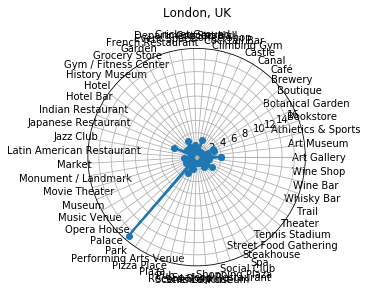

In [9]:
radar(df,'venue_category')

- We'll need a big list of categories to group if this is to work for other cities.
- Let's create a big list of categories for several major cities and group them
- First we will create a list of cities we want to extract category data from


In [149]:
other_cities = [['Paris, France'],['LA, USA'], ['New York, USA'], ['Berlin, Germany'] , ['Amsterdam, Netherlands'], ['Moscow, Russia'], ['London, UK']]

### Define a function to extract categories for each city

In [11]:
def city_category(city_and_country):

    #First get coordinates of city 
    address = city_and_country

    geolocator = Nominatim(user_agent = "my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude


    #Extract venue data for city
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            address,
            100)

    results = requests.get(url).json()["response"]['groups'][0]['items']

    #Extract only relevant info from results and put intp a list
    categories = [(v['venue']['categories'][0]['name']) for v in results]

    return categories


### Create a long list of all categories by passing each city into the above function

In [12]:
total_categories = []
for i in range(len(other_cities)):
    cats = city_category(other_cities[i])
    total_categories.append(cats)

total_categories[:10]


[['Park',
  'Garden',
  'Church',
  'Garden',
  'Fountain',
  'Monument / Landmark',
  'Plaza',
  'Park',
  'Art Museum',
  'Plaza',
  'Performing Arts Venue',
  'Hotel',
  'Church',
  'Park',
  'Plaza',
  'Opera House',
  'Garden',
  'Sandwich Place',
  'Historic Site',
  'Monument / Landmark',
  'Bookstore',
  'Hotel',
  'Park',
  'Breakfast Spot',
  'Bookstore',
  'Park',
  'Art Museum',
  'Canal',
  'Pedestrian Plaza',
  'Wine Bar',
  'Asian Restaurant',
  'Hotel',
  'Department Store',
  'Tennis Court',
  'Indie Movie Theater',
  'Concert Hall',
  'Pastry Shop',
  'Furniture / Home Store',
  'Park',
  'Hotel',
  'Hotel',
  'Bistro',
  'Boutique',
  'Wine Bar',
  'Tennis Court',
  'Museum',
  'Hotel',
  'French Restaurant',
  'Hotel',
  'Boutique',
  'Concert Hall',
  'Hotel',
  'Hotel',
  'Art Museum',
  'Bar',
  'Tennis Court',
  'Hotel',
  'Plaza',
  'Plaza',
  'Hotel',
  'Trattoria/Osteria',
  'Seafood Restaurant',
  'Bistro',
  'Bookstore',
  'Concert Hall',
  'Pastry Shop',
 

We now have a list of lists (one list for each city), we should expand these into 1 long list so it's easier to use

In [13]:
total_categories = [item for sublist in total_categories for item in sublist]

Remove duplicates by converting list to a set. Convert back to a list after, again so it's easier to use

In [14]:
print('Number of categories before removing dupes: ' + str(len(total_categories)))

total_categories = list(set(total_categories))

print('Number of categories after removing dupes: ' + str(len(total_categories)))

Number of categories before removing dupes: 700
Number of categories after removing dupes: 169


## Create new catergory groups
- Can create any number of groups, I've listed 8 so visualisations will look cleaner <br><br>

- Nightlife
- Shopping
- Food/Drink
- Points of intereset
- Parks
- Culture
- Entertainment
- Hotel/Accomodation

In [15]:
category_groups = ['Nightlife', 'Shopping', 'Food', 'Parks', 'Entertainment', 'Accomodation', 'Culture','Leisure']

## List some keywords associated with each group
- We will use these to create our groups. If a category contains a keyword, it will be assigned that group
- This may not assign every single category to a group but will catch most

In [16]:
nightlife_keywords = ['Bar','Club','Pub','Gastropub','Nightclub','Beer','Brewery','Nightlife']
shopping_keywords = ['Store', 'Shop', 'Supermarket', 'Market', 'Mall', 'Shopping','Boutique']
food_keywords = ['Restaurant', 'Burger', 'Joint','Wings', 'Breakfast', 'Coffee', 'Café','Bakery','Food','Bistro','Place']
parks_keywords = ['Park','Garden', 'Field' ,'Fountain','Forest','Lake','Mountain']
entertainment_keywords = ['Theater', 'Stadium', 'Music', 'Comedy', 'Studio', 'Art','Entertainment','Concert']
accomodation_keywords = ['Landmark','Hotel','Hostel','Accomodation']
culture_keywords = ['Church','Museum', 'Cathedral', 'Historic', 'Castle','Cultural','Palace','Plaza','House']
leisure_keywords = ['Gym', 'Fitness','Tennis','Course','Spa','Sauna']

#Create a list of lists for keywords, this is what we will use to assign each category
total_keywords = [nightlife_keywords, shopping_keywords, food_keywords, parks_keywords, entertainment_keywords,accomodation_keywords, culture_keywords, leisure_keywords]

#pd.Series([len(x) for x in total_keywords]).sum()

## Assign categories to groups
- Now we have our groups and keyword associations we can assign categories to a group
- We'll then put them into a dictionary for easy mapping

In [17]:
#create empty dictionary
category_dict = dict()

#for each group extract which categories contain any of their keywords
for x in range(len(total_keywords)):
    
    #Loop through each group checking which categories contain any of their keywords, returns a list of tuples of form (category, group)
    a=[(i,str(category_groups[x])) for e in total_keywords[x] for i in total_categories if e in i]
    
    #add to dictionary with category as key and group as value
    for i in range(len(a)):
        category_dict[a[i][0]] = a[i][1]


## Assign missing categories to 'Other'
- Missing categories are ones that do not contain any keywords
- Currently have 19 missing categories (of 166)

In [18]:
#create empty list
missing =[]
for i in total_categories:
    #append categorires that are not in our dictionary i.e. they don't have a matching keyword
    if i not in category_dict:
        missing.append(i)
missing = list(set(missing))

#add them to the dictionary as 'Other'
for x in range(len(missing)):
    category_dict[missing[x]] = 'Other'

print(len(missing))
missing

22


['Deli / Bodega',
 'Athletics & Sports',
 'Multiplex',
 'Trattoria/Osteria',
 'Distillery',
 'Canal Lock',
 'Trail',
 'Lounge',
 'Steakhouse',
 'Capitol Building',
 'Surf Spot',
 'Aquarium',
 'Road',
 'Government Building',
 'Scenic Lookout',
 'Skating Rink',
 'Canal',
 'Bookstore',
 'Vacation Rental',
 'Harbor / Marina',
 'Bike Rental / Bike Share',
 'Cricket Ground']

### Add new grouped category to our dataframe

In [19]:
df['category_group'] = df['venue_category'].map(category_dict)
df.tail()

city_name   city_lat  city_long               venue_name  venue_lat  \
95  London, UK  51.507322  -0.127647  Monmouth Coffee Company  51.505536   
96  London, UK  51.507322  -0.127647          Fortnum & Mason  51.508559   
97  London, UK  51.507322  -0.127647           Bottle Apostle  51.537515   
98  London, UK  51.507322  -0.127647         Trafalgar Square  51.508026   
99  London, UK  51.507322  -0.127647               Black Rock  51.521326   

    venue_long    venue_category  distance_from_city_centre category_group  
95   -0.091480       Coffee Shop                   2.518978           Food  
96   -0.138405  Department Store                   0.759440       Shopping  
97   -0.044658         Wine Shop                   6.667959       Shopping  
98   -0.127870             Plaza                   0.079900        Culture  
99   -0.084673        Whisky Bar                   3.365603      Nightlife

### Plotting the radar chart again it's now much clearer!

- We can now see that of London's top 100 venues, Parks and Food appear the most common categories

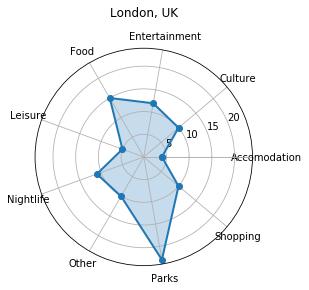

In [20]:
radar(df,'category_group')

## Combine all above steps into a function so we can apply to other cities

In [138]:
def cityvenues(city_and_country, number_of_top_venues):
    

    #First get coordinates of city 
    address = city_and_country

    geolocator = Nominatim(user_agent = "my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude


    #Extract venue data for city
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            address,
            number_of_top_venues)

    results = requests.get(url).json()["response"]['groups'][0]['items']


    #Extract only relevant info from results
    venues = [(address, latitude, longitude, v['venue']['name'], 
    v['venue']['location']['lat'], 
    v['venue']['location']['lng'],  
    v['venue']['categories'][0]['name']) for v in results]


    #Put venues details into a dataframe
    df = pd.DataFrame(venues)
    df.columns = ['city_name' ,'city_lat','city_long','venue_name','venue_lat','venue_long','venue_category']
    
    #add category groups
    df['category_group'] = df['venue_category'].map(category_dict)

    #Calculate distance from centre for each venue
    df['distance_from_city_centre'] = [geopy.distance.vincenty((df['city_lat'][x],df['city_long'][x]),(df['venue_lat'][x],df['venue_long'][x])).km for x in df.index]

    #get dummy varbiables for each category
    df_onehot = pd.DataFrame(pd.get_dummies(df[['category_group']], prefix="", prefix_sep="").sum()).reset_index()
    df_onehot.columns = ['category_group','count']

    #Create radar plot to viasualse major categories
    labels=np.array(list(df_onehot['category_group']))
    stats=df_onehot['count']

    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False) # Set the angle
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))  # Closed
    angles=np.concatenate((angles,[angles[0]]))  # Closed

    fig=plt.figure()
    ax = fig.add_subplot(111, polar=True)   # Set polar axis
    ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, labels)  # Set the label for each axis
    #Chart title needed an if statement so it can handle lists of cities and individual inputs
    if len(city_and_country) ==1:
         ax.set_title(str(city_and_country[0]) + str('\n'))
    else:
        ax.set_title(city_and_country + str('\n'))
    #ax.set_rlim(0,250)
    ax.grid(True)
    

    return


## Check attributes for other cities
- We can now visually compare different cities based on their top x number of venues

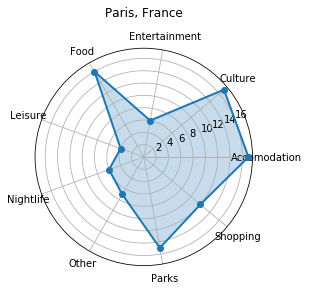

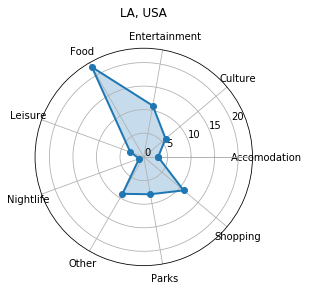

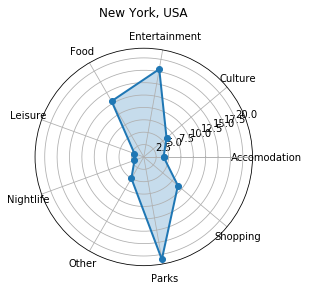

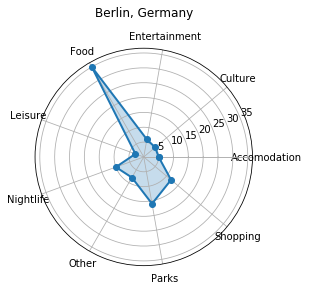

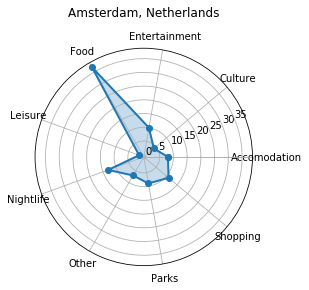

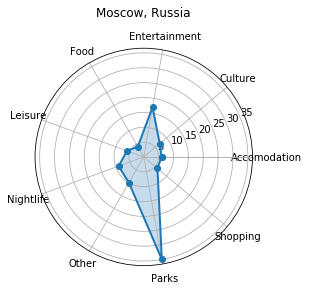

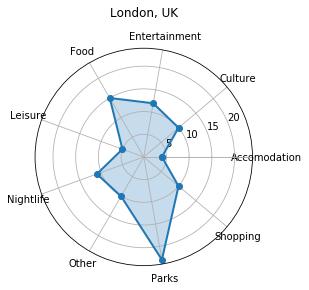

In [150]:

for x in range(len(other_cities)):
    cityvenues(other_cities[x],100)

## We can now use this function to check the attributes of any city
- See examples below

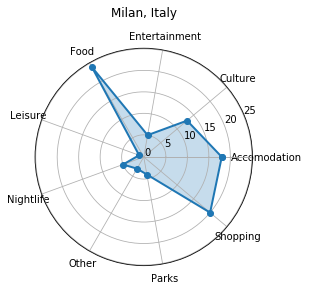

In [163]:
cityvenues('Milan, Italy',100)